### Regression analysis
In this notebook regression analysis of the price of bitcoin is evaluated. The dataset is analyzed in the _data analysis_ file which contains all of the details. The following features are taken into account:
- the total number of confirmed transactions per day 
- google search trends
- SP500 index value 
- gold price 

The other features are either not correlated with the price of bitcoin or strongly connected with each other (what could lead to an incorrect model)

Time period for the data is between 01.2014 and 04.2020

The dataset is divided into two subsets: a training set and a test set. The training set is used for fitting a model. Evaluation of a model is carry out calculating _root mean squared error_ (RMSE), $ R^2$ factor and residual plots.  

$$ RMSE = \sqrt{\frac{(y_1 - \hat{y_1})^2 + ... + ( y_n - \hat{y_n})^2}{n}} $$

where:
- $y$ - true price <br>
- $\hat{y}$ - predicted price
- $n$ - number of observations in a dataset

In [119]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import probplot
from sklearn.model_selection import train_test_split, KFold,cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

__Loading the dataset__

In [108]:
data=pd.read_csv('data_cleaning\Bitcoin_dataset_updated.csv',index_col='Date')
data.index=pd.to_datetime(data.index,format='%Y-%m-%d')
data.fillna(method='ffill',inplace=True)

In [109]:
X=data[['n-transactions','btc search trends','Gold price[USD]','SP500 close index']]
y=data['BTC price [USD]']

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.5, shuffle=True)

#### 1.Multilinear regression
 

In [110]:
lr=LinearRegression()
lr.fit(X_train,y_train)
y_train_predicted=lr.predict(X_train)
y_test_predicted=lr.predict(X_test)
RMSE_train=mean_squared_error(y_train,y_train_predicted,squared=False)
RMSE_test=mean_squared_error(y_test,y_test_predicted,squared=False)
R2_train=r2_score(y_train,y_train_predicted)
print('Train set: RMSE={}, R2={}'.format(round(RMSE_train,2),round(R2_train,4)))
print('Test set: RMSE={}'.format(round(RMSE_test,2)))

Train set: RMSE=1247.01, R2=0.8983
Test set: RMSE=1213.05


Residual plots

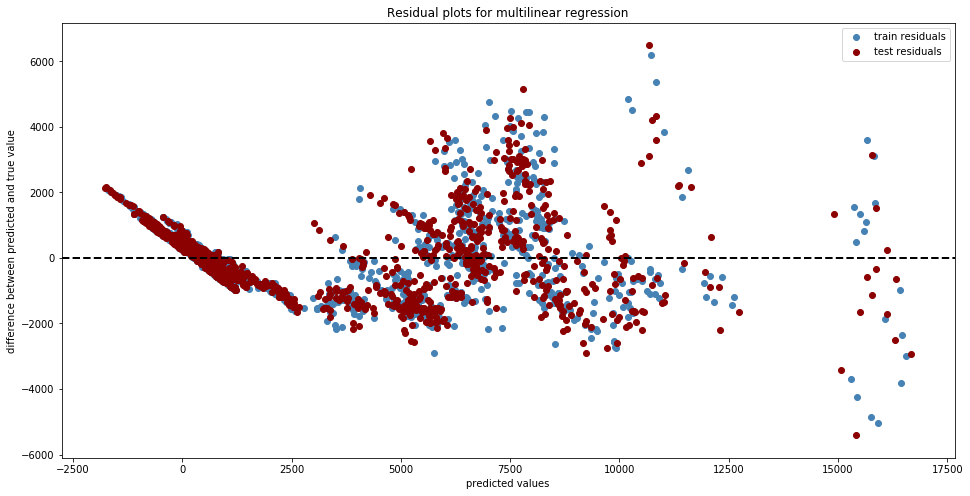

In [111]:
fig,ax=plt.subplots(figsize=(16,8))

residuals_train=y_train-y_train_predicted
residuals_test=y_test-y_test_predicted

ax.scatter(y_train_predicted,residuals_train,c='steelblue',label='train residuals')
ax.scatter(y_test_predicted,residuals_test,c='darkred',label='test residuals')
ax.axhline(y=0,lw=2,ls='--',color='black')
ax.set(xlabel='predicted values',ylabel='difference between predicted and true value')
ax.legend()
ax.set_title('Residual plots for multilinear regression')
plt.show()

Probability plot of residuals against the quantiles

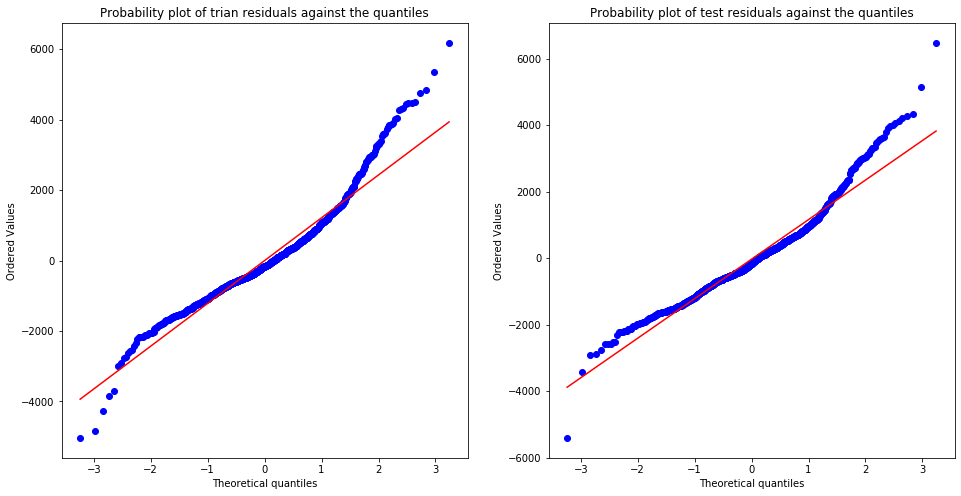

In [112]:
fig,ax=plt.subplots(ncols=2,figsize=(16,8))
probplot(residuals_train, dist='norm', fit=True, plot=ax[0], rvalue=False)
probplot(residuals_test, dist='norm', fit=True, plot=ax[1], rvalue=False)
ax[0].set_title('Probability plot of trian residuals against the quantiles')
ax[1].set_title('Probability plot of test residuals against the quantiles')
plt.show()

Predicted and true prices in function of time

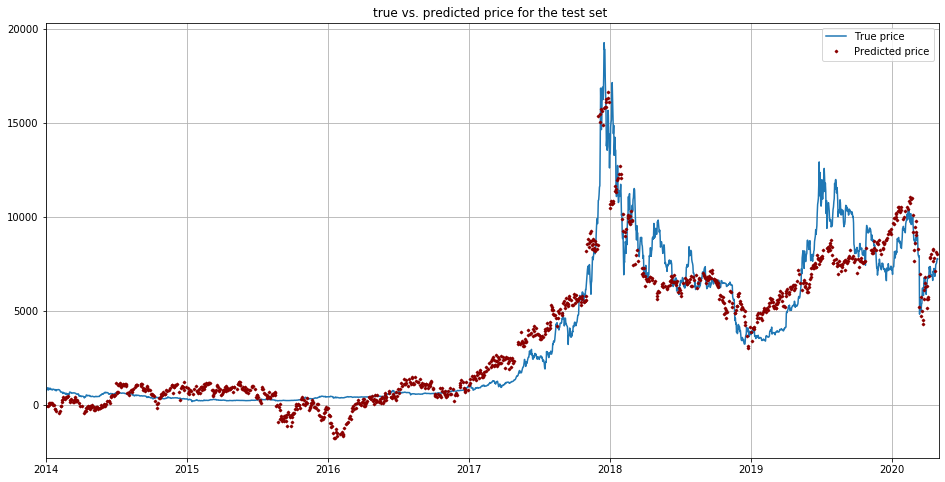

In [113]:
datemin = datetime.date(data.index.min().year, data.index.min().day-1, 1)
datemax = datetime.date(data.index.max().year, data.index.max().month + 1, 1)

price_prediction=pd.DataFrame(columns=['true price','predicted price','difference'])
price_prediction['true price']=y_test
price_prediction['predicted price']=y_test_predicted
price_prediction['difference']=residuals_test
price_prediction.sort_index(inplace=True)

plt.figure(figsize=(16,8))
plt.plot(data.index,data['BTC price [USD]'],'-',label='True price')
plt.plot(price_prediction.index,price_prediction['predicted price'],'D',markersize=2,color='darkred',label='Predicted price')
plt.grid()
plt.title('true vs. predicted price for the test set ')
plt.xlim([datemin,datemax])
plt.legend()
plt.show()

Deeper insight into model using statsmodels library 

In [114]:
X_train_sm, X_test_sm = X_train, X_test
X_train_sm=sm.add_constant(X_train_sm)
X_test_sm=sm.add_constant(X_test_sm)
lr_sm = sm.OLS(y_train, X_train_sm)
lr_sm.fit().summary()

C:\Users\Bonias\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        BTC price [USD]   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     2542.
Date:                Wed, 17 Jun 2020   Prob (F-statistic):               0.00
Time:                        20:22:47   Log-Likelihood:                -9880.8
No. Observations:                1156   AIC:                         1.977e+04
Df Residuals:                    1151   BIC:                         1.980e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.731e+04    456.979    -37.882      0.000   -1.82e+04   -1.64e+04
n-transactions       -0.0060      0.001    -10.324      0.000      -0.007      -0.005
btc search trends   126.7760      2.950     42.969      0.000     120.987     132.565
Gold price[USD]       3.3365      0.415      8.038      0.000       2.522       4.151
SP500 close index     6.8141      0.158     43.236      0.000       6.505       7.123
==============================================================================
Omnibus:                      184.297   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              446.889
Skew:                           0.869   Prob(JB):                     9.11e-98
Kurtosis:                       5.502   Cond. No.                     2.92e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.92e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 2. Polynomial regression

In order to evaluate polynominal regression transformed versions of the predictors are added to the model. The model is in the form:
$$ Y=X+\sqrt{X} + X^2 + X^3 $$

In [115]:
X_nonlinear=X.copy()
scale=['square root','squared','cubed']
scale_num=[0.5,2,3]
for i in X_nonlinear.columns:
    for j,k in zip(scale,scale_num):
        name = j + " " + str(i)  
        X_nonlinear[name]=X_nonlinear[i]**k
X_nonlinear.head()

,n-transactions,btc search trends,Gold price[USD],SP500 close index,square root n-transactions,squared n-transactions,cubed n-transactions,square root btc search trends,squared btc search trends,cubed btc search trends,square root Gold price[USD],squared Gold price[USD],cubed Gold price[USD],square root SP500 close index,squared SP500 close index,cubed SP500 close index
Date,,,,,,,,,,,,,,,,
2014-01-02,54770.0,8,1225.0,1831.98,234.029913,2.999753e+09,1.642965e+14,2.828427,64,512,35.000000,1500625.00,1.838266e+09,42.801635,3.356151e+06,6.148401e+09
2014-01-03,60980.0,8,1238.4,1831.37,246.941289,3.718560e+09,2.267578e+14,2.828427,64,512,35.190908,1533634.56,1.899253e+09,42.794509,3.353916e+06,6.142261e+09
2014-01-04,52052.0,8,1238.4,1831.37,228.149074,2.709411e+09,1.410302e+14,2.828427,64,512,35.190908,1533634.56,1.899253e+09,42.794509,3.353916e+06,6.142261e+09
2014-01-05,58662.0,8,1238.4,1831.37,242.202395,3.441230e+09,2.018694e+14,2.828427,64,512,35.190908,1533634.56,1.899253e+09,42.794509,3.353916e+06,6.142261e+09
2014-01-06,67358.0,8,1237.8,1826.77,259.534198,4.537100e+09,3.056100e+14,2.828427,64,512,35.182382,1532148.84,1.896494e+09,42.740730,3.337089e+06,6.096093e+09


In [116]:
X_train_nl, X_test_nl, y_train, y_test = train_test_split(X_nonlinear,y,train_size=0.5, shuffle=True)

In [117]:
lr_nl=LinearRegression()
lr_nl.fit(X_train_nl,y_train)
y_train_predicted_nl=lr_nl.predict(X_train_nl)
y_test_predicted_nl=lr_nl.predict(X_test_nl)
RMSE_train_nl=mean_squared_error(y_train,y_train_predicted_nl,squared=False)
RMSE_test_nl=mean_squared_error(y_test,y_test_predicted_nl,squared=False)
R2_train_nl=r2_score(y_train,y_train_predicted_nl)
print('Train set: RMSE={}, R2={}'.format(round(RMSE_train_nl,2),round(R2_train_nl,4)))
print('Test set: RMSE={}'.format(round(RMSE_test_nl,2)))

Train set: RMSE=1220.28, R2=0.8999
Test set: RMSE=1245.32


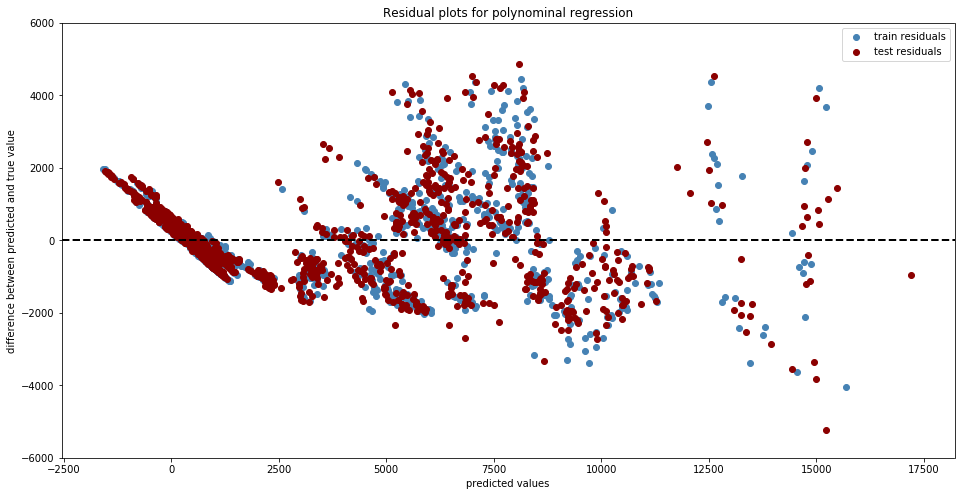

In [118]:
fig,ax=plt.subplots(figsize=(16,8))

residuals_train_nl=y_train-y_train_predicted_nl
residuals_test_nl=y_test-y_test_predicted_nl

ax.scatter(y_train_predicted_nl,residuals_train_nl,c='steelblue',label='train residuals')
ax.scatter(y_test_predicted_nl,residuals_test_nl,c='darkred',label='test residuals')
ax.axhline(y=0,lw=2,ls='--',color='black')
ax.set(xlabel='predicted values',ylabel='difference between predicted and true value')
ax.set_ylim(-6000,6000)
ax.legend()
ax.set_title('Residual plots for polynominal regression')
plt.show()

Because the results obtained using polynominal regression hardly differ from the results obtained using multilinear regression further investigation is not necessary

### Summary:

1. In this notebook two regression models were evaluated
    - mulitilinear regression model
    - polynominal regression model
    <br> The results obtained by these models are almost the same but the polynominal regression is slightly better 

2. Residual plots suggest that the models are unable to capture some explanatory information (a parabolic pattern is noticable) although $ R^2 $ factor is quite high 
3. RMSE equals $ \approx 1200 $ what is a meaningul fraction of the current bitcoin price (17.06.2020) as well as all time high price
4. The models predict negative prices what is senseless
5. The biggest differences in price prediction are in the order of five thousand what is a huge difference

### Conclusion

Regression models are inccorect for bitcoin price prediction.

